In [1]:
from __future__ import absolute_import, division, print_function

# Data Exploration

In this notebook I will explore the data and ascertain their structure. 

## Imports

In [2]:
import os
import pickle
import time

import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap


%matplotlib inline

## Table of contents

1. [Functions](#Functions)

2. [Data](#Data)

2. [NaN values](#NaN values)

2. [Convert date column to datetime format](#Convert date column to datetime format)

2. [General comments on the features](#General comments on the features)

2. [A closer look](#A closer look)

2. [Locations](#Locations)

2. [Format of the data](#Format of the data)

2. [Precipitation](#Precipitation)

2. [Temperature](#Temperature)

2. [Time series](#Time series)

2. [Impute missing values](#Impute missing values)

2. [Basic statistics](#Basic statistics)

2. [Correlations](#Correlations)

2. [Drop features/columns](#Drop features/columns)

2. [Save cleaned data to disk](#Save cleaned data to disk)





**Note:** For the internal links in the table of contents to work, please open the notebook in the Jupyter notebook viewer <a href="http://nbviewer.jupyter.org/github/cleipski/CropPredict/blob/master/01_data_exploration.ipynb" target="_blank">here</a>.

<a id='Functions'></a>
## Functions

In [3]:
# Calculate distance given long/lat
from math import radians, cos, sin, asin, sqrt

def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2. * asin(sqrt(a)) 
    r = 6371. # Radius of earth in kilometers. Use 3956 for miles
    return c * r

In [4]:
def impute_with_nearest(in_df,in_column):
    """
    Replace missing values in 'in_column' of the data frame 'in_df' 
    with values from the same day that are closest geographically. 
    """
    # Data frame of all the 'NaN's    
    df_nan = in_df[in_df[in_column].isnull()]
    if len(df_nan) > 0:
        # Same date, similar locations
        for i in range(len(df_nan)):
            tmp_date = df_nan['Date'].iloc[i]
            tmp_long = df_nan['Longitude'].iloc[i]
            tmp_lat  = df_nan['Latitude'].iloc[i]
            tmp_index = df_nan['Latitude'].index.tolist()[i]
            condition = (((in_df['Latitude'] != tmp_lat) |
                         (in_df['Longitude'] != tmp_long)) & 
                         (in_df['Date'] == tmp_date) & 
                         (in_df[in_column].notnull())) 
            # Create temporary data frame for convenient ordering
            new_df = in_df[['Longitude', 'Latitude']][condition]
            new_df['Distance'] = new_df['Longitude']
            for j in range(len(new_df)):
                new_df['Distance'].iloc[j] = haversine(tmp_long,
                                                       tmp_lat,
                                                       new_df['Longitude'].iloc[j],
                                                       new_df['Latitude'].iloc[j])
            # Distance to nearest measurement on same day
            tmp_df = new_df.sort_values(by='Distance', ascending=True)
            tmp_min_dist = tmp_df.iloc[0,2]
            tmp_min_index = tmp_df.index.tolist()[0]
            # Replace
            old_val = in_df[in_column].iloc[tmp_index]
            new_val = in_df[in_column].iloc[tmp_min_index]
            in_df[in_column].iloc[tmp_index] = new_val


<a id='Data'></a>
## Data

In [5]:
cwd = os.getcwd()
data = os.path.join(cwd,'data','wheat-2013-supervised.csv')
df_2013 = pd.read_csv(data)
df_2013.head()

,CountyName,State,Latitude,Longitude,Date,apparentTemperatureMax,apparentTemperatureMin,cloudCover,dewPoint,humidity,...,precipTypeIsOther,pressure,temperatureMax,temperatureMin,visibility,windBearing,windSpeed,NDVI,DayInSeason,Yield
0,Adams,Washington,46.811686,-118.695237,11/30/2013 0:00,35.70,20.85,0.00,29.53,0.91,...,0,1027.13,35.70,27.48,2.46,214,1.18,134.110657,0,35.7
1,Adams,Washington,46.929839,-118.352109,11/30/2013 0:00,35.10,26.92,0.00,29.77,0.93,...,0,1026.87,35.10,26.92,2.83,166,1.01,131.506592,0,35.7
2,Adams,Washington,47.006888,-118.510160,11/30/2013 0:00,33.38,26.95,0.00,29.36,0.94,...,0,1026.88,33.38,26.95,2.95,158,1.03,131.472946,0,35.7
3,Adams,Washington,47.162342,-118.699677,11/30/2013 0:00,28.05,25.93,0.91,29.47,0.94,...,0,1026.37,33.19,27.17,2.89,153,1.84,131.288300,0,35.7
4,Adams,Washington,47.157512,-118.434056,11/30/2013 0:00,28.83,25.98,0.91,29.86,0.94,...,0,1026.19,33.85,27.07,2.97,156,1.85,131.288300,0,35.7


In [6]:
# Also read data for 2014
data = os.path.join(cwd,'data','wheat-2014-supervised.csv')
df_2014 = pd.read_csv(data)
df_2014.head()

,CountyName,State,Latitude,Longitude,Date,apparentTemperatureMax,apparentTemperatureMin,cloudCover,dewPoint,humidity,...,precipTypeIsOther,pressure,temperatureMax,temperatureMin,visibility,windBearing,windSpeed,NDVI,DayInSeason,Yield
0,Adams,Washington,46.929839,-118.352109,11/30/2014 0:00,18.61,-3.01,0.00,6.77,0.69,...,0,1027.95,23.93,6.96,10.00,9,3.80,136.179718,0,35.6
1,Adams,Washington,47.150327,-118.958859,11/30/2014 0:00,19.67,-0.74,0.00,6.66,0.65,...,0,1028.26,25.88,8.71,10.00,352,6.03,135.697540,0,35.6
2,Adams,Washington,46.811686,-118.695237,11/30/2014 0:00,20.66,-0.14,0.00,6.55,0.67,...,0,1028.29,24.67,8.26,10.00,25,3.59,135.676956,0,35.6
3,Adams,Washington,47.162342,-118.699677,11/30/2014 0:00,19.69,-2.66,0.03,7.32,0.69,...,0,1027.74,25.48,8.10,10.00,1,5.18,135.005798,0,35.6
4,Adams,Washington,47.157512,-118.434056,11/30/2014 0:00,18.82,-3.04,0.04,7.62,0.70,...,0,1027.16,24.83,8.32,9.99,5,4.69,134.803864,0,35.6


<a id='NaN values'></a>
## NaN values

In [7]:
# Check the general properties of the DFs
df_2013.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 177493 entries, 0 to 177492
Data columns (total 26 columns):
CountyName                177493 non-null object
State                     177493 non-null object
Latitude                  177493 non-null float64
Longitude                 177493 non-null float64
Date                      177493 non-null object
apparentTemperatureMax    177493 non-null float64
apparentTemperatureMin    177493 non-null float64
cloudCover                177493 non-null float64
dewPoint                  177493 non-null float64
humidity                  177493 non-null float64
precipIntensity           177492 non-null float64
precipIntensityMax        177492 non-null float64
precipProbability         177492 non-null float64
precipAccumulation        177493 non-null float64
precipTypeIsRain          177493 non-null int64
precipTypeIsSnow          177493 non-null int64
precipTypeIsOther         177493 non-null int64
pressure                  177239 non-null float6

In [8]:
df_2014.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 182549 entries, 0 to 182548
Data columns (total 26 columns):
CountyName                182549 non-null object
State                     182549 non-null object
Latitude                  182549 non-null float64
Longitude                 182549 non-null float64
Date                      182549 non-null object
apparentTemperatureMax    182549 non-null float64
apparentTemperatureMin    182549 non-null float64
cloudCover                182549 non-null float64
dewPoint                  182549 non-null float64
humidity                  182549 non-null float64
precipIntensity           182549 non-null float64
precipIntensityMax        182549 non-null float64
precipProbability         182549 non-null float64
precipAccumulation        182549 non-null float64
precipTypeIsRain          182549 non-null int64
precipTypeIsSnow          182549 non-null int64
precipTypeIsOther         182549 non-null int64
pressure                  182198 non-null float6

For both years I have 26 columns with ~177k rows for 2013 and ~183k rows for 2014. All columns show the expected format for the data they contain (float, integer, string). However, for each year a number of columns have a few entries that are 'NaN' (compare number on non-null entries with total number of rows).

In [9]:
# Let's verify
df_2013.isnull().sum()

CountyName                  0
State                       0
Latitude                    0
Longitude                   0
Date                        0
apparentTemperatureMax      0
apparentTemperatureMin      0
cloudCover                  0
dewPoint                    0
humidity                    0
precipIntensity             1
precipIntensityMax          1
precipProbability           1
precipAccumulation          0
precipTypeIsRain            0
precipTypeIsSnow            0
precipTypeIsOther           0
pressure                  254
temperatureMax              0
temperatureMin              0
visibility                 30
windBearing                 0
windSpeed                   0
NDVI                        0
DayInSeason                 0
Yield                       0
dtype: int64

In [10]:
df_2014.isnull().sum()

CountyName                  0
State                       0
Latitude                    0
Longitude                   0
Date                        0
apparentTemperatureMax      0
apparentTemperatureMin      0
cloudCover                  0
dewPoint                    0
humidity                    0
precipIntensity             0
precipIntensityMax          0
precipProbability           0
precipAccumulation          0
precipTypeIsRain            0
precipTypeIsSnow            0
precipTypeIsOther           0
pressure                  351
temperatureMax              0
temperatureMin              0
visibility                 16
windBearing                 0
windSpeed                   0
NDVI                        0
DayInSeason                 0
Yield                       0
dtype: int64

In 2013, five features have 'NaN' values, in 2014 only 2 features. The feature with the highest number of 'NaNs' is 'pressure' followed by 'visibilty' for both years. All missing values are from features that are weather related.

<a id='Convert date column to datetime format'></a>
## Convert date column to datetime format

In [11]:
# Check if already converted b/c it takes a long time to process
now = time.time()
if not df_2013['Date'].dtype == np.dtype('datetime64[ns]'):
    df_2013['Date'] = df_2013['Date'].apply(pd.to_datetime)
print('Exec. time: {:5.2f} s'.format(time.time()-now))

Exec. time: 89.28 s


In [12]:
# Check if already converted b/c it takes a long time to process
now = time.time()
if not df_2014['Date'].dtype == np.dtype('datetime64[ns]'):
    df_2014['Date'] = df_2014['Date'].apply(pd.to_datetime)
print('Exec. time: {:5.2f} s'.format(time.time()-now))

Exec. time: 94.60 s


<a id='General comments on the features'></a>
## General comments on the features

There are a number of features/columns in the dataset where it is not readily apparent what the encode or what their units are. Common definitions are:

* precipIntensity: Millimeters per hour.
* precipIntensityMax: Millimeters per hour.
* precipAccumulation: Centimeters (daily).
* NDVI: "The normalized difference vegetation index (NDVI) is a simple graphical indicator that can be used to analyze remote sensing measurements, typically but not necessarily from a space platform, and assess whether the target being observed contains live green vegetation or not." (source: Wikipedia).
* apparentTemperature is the perceived temperature in degrees Fahrenheit derived from either a combination of temperature and wind (Wind Chill) or temperature and humidity (Heat Index) for the indicated hour. When the temperature at a particular grid point falls to 50°F or less, wind chill will be used for that point for the Apparent Temperature. When the temperature at a grid point rises above 80°F, the heat index will be used for Apparent Temperature.  Between 51 and 80°F, the Apparent Temperature will be the ambient air temperature. (http://www.nws.noaa.gov/ndfd/definitions.htm)

<a id='A closer look'></a>
## A closer look

Before I can decide what to do about the NaN values (e.g., impute, drop, ...) I need to understand the data better. In the following I will perform some exploration into the structure of the data.

In [13]:
# Check that both years have the same columns
features_2013 = df_2013.columns
features_2014 = df_2013.columns
print('Number of features (2013):', len(features_2013))
print('Number of features (2014):', len(features_2014))
print('Number of features in common: ', len(set(features_2013).intersection(features_2014)))
# features_2013 & features_2014

Number of features (2013): 26
Number of features (2014): 26
Number of features in common:  26


In [14]:
# Check the unique entries in each feature
features = df_2013.columns
for feature in features:
    n_unique_2013 = len(df_2013[feature].unique())
    n_unique_2014 = len(df_2014[feature].unique())
    print('{:25} : {:6.0f} {:6.0f}'.format(feature,n_unique_2013,n_unique_2014))
print('---------------------')
print('Total number of observations (2013) : {}'.format(df_2013.shape[0]))
print('Total number of observations (2014) : {}'.format(df_2014.shape[0]))

CountyName                :    150    156
State                     :      5      5
Latitude                  :   1014   1035
Longitude                 :   1014   1035
Date                      :    186    186
apparentTemperatureMax    :  11290   9941
apparentTemperatureMin    :  10916   9960
cloudCover                :    101    101
dewPoint                  :   8909   8331
humidity                  :     93     86
precipIntensity           :    662    815
precipIntensityMax        :   3132   4184
precipProbability         :     98     98
precipAccumulation        :   2761   1911
precipTypeIsRain          :      2      2
precipTypeIsSnow          :      2      2
precipTypeIsOther         :      1      1
pressure                  :   5117   4656
temperatureMax            :  10408   8323
temperatureMin            :   9329   8494
visibility                :    877    900
windBearing               :    360    360
windSpeed                 :   2694   2341
NDVI                      : 125108

* The numerical columns have a large number of levels. There seems to be no obvious feature that should be treated as a multi-level categorical feature.
* There seem to be more counties and locations in 2014 than in 2013. Need to verify.


Check the min/max 'Yield' for each county. As in the description of the data:

".. this yield label is not specific to a lat/long but is for the county. Multiple lat/longs will have the same yield since they fall into a single county, even if that individual farm had a higher or lower localized yield."

In [15]:
gb = df_2013.groupby(by='CountyName')
gb_agg = gb.agg({'Yield' : {'Count' : lambda x: len(x.unique())}})
diff_counties_2013 = gb_agg[gb_agg['Yield']['Count'] > 1].index.get_level_values('CountyName').values
gb_agg[gb_agg['Yield']['Count'] > 1]

,Yield
,Count
CountyName,
Blaine,2.0
Brown,2.0
Clay,2.0
Comanche,2.0
Custer,2.0
Douglas,2.0
Ellis,3.0
Franklin,2.0


In [16]:
gb = df_2014.groupby(by='CountyName')
gb_agg = gb.agg({'Yield' : {'Count' : lambda x: len(x.unique())}})
diff_counties_2014 = gb_agg[gb_agg['Yield']['Count'] > 1].index.get_level_values('CountyName').values
gb_agg[gb_agg['Yield']['Count'] > 1]

,Yield
,Count
CountyName,
Blaine,2.0
Brown,2.0
Carter,2.0
Comanche,3.0
Douglas,2.0
Ellis,3.0
Franklin,2.0
Grant,3.0


Interestingly, many counties have only one value for the yield (number of counties: 150 (2013) and 156 (2014)). A few exceptions, as printed above, have more than one value. Before moving on I need to understand what's going on and how these yield values are assigned. Why do most counties have only one value, but a sizeable fraction has several diffenet values?

In [17]:
# What states do the counties with various yield levels lie in?
print('I count {} counties with more than one yield level.'.format(len(diff_counties_2013)))
for idx, diff_county in enumerate(diff_counties_2013):
    print('{:10} {}'.format(diff_county, df_2013['State'][df_2013['CountyName'] == diff_county].unique()))

I count 19 counties with more than one yield level.
Blaine     ['Montana' 'Oklahoma']
Brown      ['Kansas' 'Texas']
Clay       ['Kansas' 'Texas']
Comanche   ['Kansas' 'Oklahoma']
Custer     ['Montana' 'Oklahoma']
Douglas    ['Kansas' 'Washington']
Ellis      ['Kansas' 'Oklahoma' 'Texas']
Franklin   ['Kansas' 'Washington']
Garfield   ['Montana' 'Oklahoma' 'Washington']
Grant      ['Kansas' 'Oklahoma' 'Washington']
Gray       ['Kansas' 'Texas']
Hamilton   ['Kansas' 'Texas']
Harper     ['Kansas' 'Oklahoma']
Hill       ['Montana' 'Texas']
Jackson    ['Kansas' 'Oklahoma']
Johnson    ['Kansas' 'Texas']
Lincoln    ['Kansas' 'Washington']
Logan      ['Kansas' 'Oklahoma']
Marshall   ['Kansas' 'Oklahoma']


In [18]:
# What states do the counties with various yield levels lie in?
print('I count {} counties with more than one yield level.'.format(len(diff_counties_2014)))
for idx, diff_county in enumerate(diff_counties_2014):
    print('{:10} {}'.format(diff_county, df_2014['State'][df_2014['CountyName'] == diff_county].unique()))

I count 14 counties with more than one yield level.
Blaine     ['Montana' 'Oklahoma']
Brown      ['Kansas' 'Texas']
Carter     ['Montana' 'Oklahoma']
Comanche   ['Kansas' 'Oklahoma' 'Texas']
Douglas    ['Kansas' 'Washington']
Ellis      ['Kansas' 'Oklahoma' 'Texas']
Franklin   ['Kansas' 'Washington']
Grant      ['Kansas' 'Oklahoma' 'Washington']
Hamilton   ['Kansas' 'Texas']
Harper     ['Kansas' 'Oklahoma']
Hill       ['Montana' 'Texas']
Jackson    ['Kansas' 'Oklahoma']
Jefferson  ['Kansas' 'Oklahoma']
Lincoln    ['Oklahoma' 'Washington']


Okay, it seems that counties with the same name can appear in two (or even three) different states. That explaines the different values for the yield. However, some of the counties having two different yield values in 2013 (e.g., Clay) do not show up in the same list in 2014. There are also examples of the opposite (e.g., Jefferson). I can think of two reasons at this point:
* the county still shows up for more than one state, but both entries happen to have the same yield
* the county only shows up for one of the states

Let's investigate.

In [19]:
print('{:10} {:35} {}'.format('County 2013', 'State 2014', 'Yield 2014'))
print('----------------------------------------------------------------')
for idx, diff_county in enumerate(diff_counties_2013):
    tmp_states = df_2014['State'][df_2014['CountyName'] == diff_county].unique()
    tmp_yields = np.zeros(len(tmp_states))
    for ix,tmp_state in enumerate(tmp_states):
        tmp_yields[ix] = df_2014['Yield'][(df_2014['CountyName'] == diff_county) & 
                                          (df_2014['State'] == tmp_state)].unique()

    print('{:10} {:35} {}'.format(diff_county, tmp_states, tmp_yields))

County 2013 State 2014                          Yield 2014
----------------------------------------------------------------
Blaine     ['Montana' 'Oklahoma']              [ 32.4  26.6]
Brown      ['Kansas' 'Texas']                  [ 42.   21.4]
Clay       ['Texas']                           [ 25.2]
Comanche   ['Kansas' 'Oklahoma' 'Texas']       [ 41.5  20.9  30.3]
Custer     ['Oklahoma']                        [ 30.3]
Douglas    ['Kansas' 'Washington']             [ 30.9  37.8]
Ellis      ['Kansas' 'Oklahoma' 'Texas']       [ 32.9  22.4  39.3]
Franklin   ['Kansas' 'Washington']             [ 39.9  30. ]
Garfield   ['Oklahoma']                        [ 27.3]
Grant      ['Kansas' 'Oklahoma' 'Washington']  [ 33.5  23.6  41.7]
Gray       ['Kansas']                          [ 46.6]
Hamilton   ['Kansas' 'Texas']                  [ 20.5  26.1]
Harper     ['Kansas' 'Oklahoma']               [ 27.7  27.5]
Hill       ['Montana' 'Texas']                 [ 28.2  43. ]
Jackson    ['Kansas' 'Oklaho

In [20]:
print('{:10} {:35} {}'.format('County 2014', 'State 2013', 'Yield 2013'))
print('----------------------------------------------------------------')
for idx, diff_county in enumerate(diff_counties_2014):
    tmp_states = df_2013['State'][df_2013['CountyName'] == diff_county].unique()
    tmp_yields = np.zeros(len(tmp_states))
    for ix,tmp_state in enumerate(tmp_states):
        tmp_yields[ix] = df_2013['Yield'][(df_2013['CountyName'] == diff_county) & 
                                          (df_2013['State'] == tmp_state)].unique()
    print('{:10} {:35} {}'.format(diff_county, tmp_states, tmp_yields))


County 2014 State 2013                          Yield 2013
----------------------------------------------------------------
Blaine     ['Montana' 'Oklahoma']              [ 38.4  18.1]
Brown      ['Kansas' 'Texas']                  [ 51.2  13.6]
Carter     ['Montana']                         [ 40.9]
Comanche   ['Kansas' 'Oklahoma']               [ 14.5  15.3]
Douglas    ['Kansas' 'Washington']             [ 44.8  35.3]
Ellis      ['Kansas' 'Oklahoma' 'Texas']       [ 19.9  10.2  54.9]
Franklin   ['Kansas' 'Washington']             [ 47.4  31.3]
Grant      ['Kansas' 'Oklahoma' 'Washington']  [ 27.7  12.7  42.9]
Hamilton   ['Kansas' 'Texas']                  [ 12.1  27. ]
Harper     ['Kansas' 'Oklahoma']               [ 12.6  10.3]
Hill       ['Montana' 'Texas']                 [ 38.8  49.4]
Jackson    ['Kansas' 'Oklahoma']               [ 45.4  11.8]
Jefferson  ['Oklahoma']                        [ 20.6]
Lincoln    ['Kansas' 'Washington']             [ 23.3  48. ]


This exercise reveals that counties that show up in more than one state in one year in most cases show up in more than one state in the next year as well. Exceptions to this rule are:

* Clay: ['Kansas' 'Texas'] in 2013, ['Texas'] in 2014
* Custer: ['Montana' 'Oklahoma'] in 2013, ['Oklahoma'] in 2014
* Garfield: ['Montana' 'Oklahoma' 'Washington'] in 2013, ['Oklahoma'] in 2014
* Gray: ['Kansas' 'Texas'] in 2013, ['Kansas'] in 2014
* Johnson: ['Kansas' 'Texas'] in 2013, ['Texas'] in 2014
* Logan: ['Kansas' 'Oklahoma'] in 2013, ['Oklahoma'] in 2014
* Marshall: ['Kansas' 'Oklahoma'] in 2013, does not appear in 2014 at all

as well as:

* Carter: ['Montana' 'Oklahoma'] in 2014, ['Montana'] in 2013
* Jefferson: ['Kansas' 'Oklahoma'] in 2014, ['Oklahoma'] in 2013

The final question here is whether or not these counties actually are two different counties in two different states, or the just the same county (with the same locations) assigned to two different states with the remaining values repeated. 

Now I will go through the counties appearning more than once and compare the locations they show for the different states.

In [67]:
for idx, diff_county in enumerate(diff_counties_2013):
    # Get all states the county is assigned to
    tmp_states = df_2013['State'][df_2013['CountyName'] == diff_county].unique()
    # Get all locations for this county across states
    tmp_locations = {}
    for ix,tmp_state in enumerate(tmp_states):
        tmp_locations[tmp_state] = df_2013['Location'][(df_2013['CountyName'] == diff_county) & 
                                                       (df_2013['State'] == tmp_state)].unique()
    loc_total = sum([len(tmp_locations[x]) for x in tmp_locations.keys()])
    loc_unique = len(np.unique(tmp_locations.values()))
    print('{:10} : {} repeated locations out of {}'.format(diff_county, loc_total-loc_unique,loc_total))


Blaine     : 0 repeated locations out of 12
Brown      : 0 repeated locations out of 12
Clay       : 0 repeated locations out of 12
Comanche   : 0 repeated locations out of 12
Custer     : 0 repeated locations out of 12
Douglas    : 0 repeated locations out of 12
Ellis      : 0 repeated locations out of 18
Franklin   : 0 repeated locations out of 12
Garfield   : 0 repeated locations out of 18
Grant      : 0 repeated locations out of 18
Gray       : 0 repeated locations out of 12
Hamilton   : 0 repeated locations out of 12
Harper     : 0 repeated locations out of 12
Hill       : 0 repeated locations out of 12
Jackson    : 0 repeated locations out of 12
Johnson    : 0 repeated locations out of 12
Lincoln    : 0 repeated locations out of 12
Logan      : 0 repeated locations out of 12
Marshall   : 0 repeated locations out of 12


In [68]:
for idx, diff_county in enumerate(diff_counties_2014):
    # Get all states the county is assigned to
    tmp_states = df_2014['State'][df_2014['CountyName'] == diff_county].unique()
    # Get all locations for this county across states
    tmp_locations = {}
    for ix,tmp_state in enumerate(tmp_states):
        tmp_locations[tmp_state] = df_2014['Location'][(df_2014['CountyName'] == diff_county) & 
                                                       (df_2014['State'] == tmp_state)].unique()
    loc_total = sum([len(tmp_locations[x]) for x in tmp_locations.keys()])
    loc_unique = len(np.unique(tmp_locations.values()))
    print('{:10} : {} repeated locations out of {}'.format(diff_county, loc_total-loc_unique,loc_total))



Blaine     : 0 repeated locations out of 12
Brown      : 0 repeated locations out of 12
Carter     : 0 repeated locations out of 12
Comanche   : 0 repeated locations out of 18
Douglas    : 0 repeated locations out of 12
Ellis      : 0 repeated locations out of 18
Franklin   : 0 repeated locations out of 12
Grant      : 0 repeated locations out of 18
Hamilton   : 0 repeated locations out of 12
Harper     : 0 repeated locations out of 12
Hill       : 0 repeated locations out of 12
Jackson    : 0 repeated locations out of 12
Jefferson  : 0 repeated locations out of 12
Lincoln    : 0 repeated locations out of 12


This confirms that all locations within counties that appear in more than one state are unique and no repetitions occur. So the counties are just named the same but are otherwise distinct.

<a id='Locations'></a>
## Locations

The analysis above already showed that Longitude and Latitude each at 1014 and 1035 unique entries in 2013 and 2014, respectively. This strongly suggests that the data contain 1014 and 1035 uniqe locations for these years. Let's verify that we actuallly have unique *pairs* of lng/lat values.

In [21]:
df_2013['Location'] = list(zip(df_2013['Longitude'], df_2013['Latitude']))
print('Number of unique locations (2013): {}'.format(len(df_2013['Location'].unique())))

Number of unique locations (2013): 1014


In [22]:
df_2014['Location'] = list(zip(df_2014['Longitude'], df_2014['Latitude']))
print('Number of unique locations (2014): {}'.format(len(df_2014['Location'].unique())))

Number of unique locations (2014): 1035


Okay, it's indeed 1014 and 1035 unique locations in 2013 and 2014, respectively.

In [174]:
loc_2013 = list(df_2013['Location'].unique())
loc_2014 = list(df_2014['Location'].unique())

matches = set(loc_2013) & set(loc_2014)
print(len(matches))

882


Out of these locations in the 2013 and 2014 data, 882 are actually in common between both years.

<a id='Format of the data'></a>
## Format of the data

Since detailed information on the structure and format of the data is not available, my analysis above provides me with further insight into the data. My current understanding is as follows:

* For each location (which falls into a certain county which again lies in a certain state) the data provide weather information for a specific day. We have essentially a location-sepcific timeseries of weather data. 
* The yield that is recorded corresponds to the yield at the end of the season (i.e, harvest). Despite the fact that it is measured at the end of the season, it is still reported for each individual location/date leading up to the hearvest. 

The given task here specifically mentions to *exclude* the date from the training. But the day in the season is available. Let's check how the season's starting data (and length) may depend on location.

In [23]:
gb_2013 = df_2013.groupby(by='Location')
gb_2014 = df_2014.groupby(by='Location')

In [24]:
gb_agg_2013 = gb_2013.agg({'Date' : {'First_Day_in_Season' : np.min},
                           'DayInSeason': {'First_Day_in_Season' : np.min,
                                           'Length_of_Season' : lambda x: np.max(x) - np.min(x)}})
gb_agg_2013.head()

Date      DayInSeason  \
                           First_Day_in_Season Length_of_Season   
Location                                                          
(-120.9140928, 45.8405591)          2013-11-30              185   
(-120.7332898, 45.8059508)          2013-11-30              185   
(-120.4850382, 45.7447958)          2013-11-30              185   
(-120.3476399, 45.8191414)          2013-11-30              185   
(-120.2148424, 45.977662)           2013-11-30              185   

                                                
                           First_Day_in_Season  
Location                                        
(-120.9140928, 45.8405591)                   0  
(-120.7332898, 45.8059508)                   0  
(-120.4850382, 45.7447958)                   0  
(-120.3476399, 45.8191414)                   0  
(-120.2148424, 45.977662)                    0

In [25]:
gb_agg_2014 = gb_2014.agg({'Date' : {'First_Day_in_Season' : np.min},
                           'DayInSeason': {'First_Day_in_Season' : np.min,
                                           'Length_of_Season' : lambda x: np.max(x) - np.min(x)}})

In [26]:
los = gb_agg_2013['DayInSeason']['Length_of_Season'].unique()
for tmp_los in los:
    cts = (gb_agg_2013['Date']['First_Day_in_Season']
           [gb_agg_2013['DayInSeason']['Length_of_Season'] == tmp_los].count())
    print('{:3} {:3}'.format(tmp_los, cts))

185 935
184   6
137   2
119   1
182   3
160   1
112  23
 64   6
152   6
177   5
 96   7
144   2
103   5
  0  12


In [167]:
los = gb_agg_2014['DayInSeason']['Length_of_Season'].unique()
for tmp_los in los:
    cts = (gb_agg_2014['Date']['First_Day_in_Season']
           [gb_agg_2014['DayInSeason']['Length_of_Season'] == tmp_los].count())
    print('{:3} {:3}'.format(tmp_los, cts))

185 971
151   2
169  13
152   4
156   1
170   6
 80   6
160  13
144   6
 64  12
128   1


The vast majority of locations has a common 'Length_of_Season' of 185 days. In 2013 there are 12 locations with only one entry in 'DayInSeason'. Maybe these locations olny appear once alltogether? Let's check:

In [27]:
locations = (gb_agg_2013[gb_agg_2013['DayInSeason']['Length_of_Season'] == 0]
             .index.get_level_values('Location').values)
for loc in locations:
    print(df_2013['Longitude'][df_2013['Location'] == loc].count())
    print(df_2013['Date'][df_2013['Location'] == loc])


1
105317   2014-03-20
Name: Date, dtype: datetime64[ns]
1
105318   2014-03-20
Name: Date, dtype: datetime64[ns]
1
105689   2014-03-20
Name: Date, dtype: datetime64[ns]
1
105688   2014-03-20
Name: Date, dtype: datetime64[ns]
1
105224   2014-03-20
Name: Date, dtype: datetime64[ns]
1
105690   2014-03-20
Name: Date, dtype: datetime64[ns]
1
105687   2014-03-20
Name: Date, dtype: datetime64[ns]
1
105226   2014-03-20
Name: Date, dtype: datetime64[ns]
1
105223   2014-03-20
Name: Date, dtype: datetime64[ns]
1
105225   2014-03-20
Name: Date, dtype: datetime64[ns]
1
105222   2014-03-20
Name: Date, dtype: datetime64[ns]
1
105685   2014-03-20
Name: Date, dtype: datetime64[ns]


In [28]:
max(df_2013['Date'])

Timestamp('2014-06-03 00:00:00')

The locations that show up only once do so in the middle of the season, not at the end.

In [29]:
for tmp_los in los:
    if tmp_los != 185:
        cts = (gb_agg_2013['Date']['First_Day_in_Season']
               [gb_agg_2013['DayInSeason']['Length_of_Season'] == tmp_los].values)
        for ct in cts:
            print('{:3} {:3}'.format(tmp_los, ct))
 

184 2013-12-01T00:00:00.000000000
184 2013-12-01T00:00:00.000000000
184 2013-12-01T00:00:00.000000000
184 2013-12-01T00:00:00.000000000
184 2013-12-01T00:00:00.000000000
184 2013-12-01T00:00:00.000000000
137 2013-12-07T00:00:00.000000000
137 2013-12-07T00:00:00.000000000
119 2013-12-25T00:00:00.000000000
182 2013-12-03T00:00:00.000000000
182 2013-12-03T00:00:00.000000000
182 2013-12-03T00:00:00.000000000
160 2013-12-01T00:00:00.000000000
112 2014-01-13T00:00:00.000000000
112 2014-01-13T00:00:00.000000000
112 2014-01-13T00:00:00.000000000
112 2014-01-13T00:00:00.000000000
112 2014-01-13T00:00:00.000000000
112 2014-01-13T00:00:00.000000000
112 2014-01-06T00:00:00.000000000
112 2014-01-06T00:00:00.000000000
112 2014-01-06T00:00:00.000000000
112 2014-01-06T00:00:00.000000000
112 2014-01-06T00:00:00.000000000
112 2014-01-06T00:00:00.000000000
112 2014-01-06T00:00:00.000000000
112 2014-01-06T00:00:00.000000000
112 2014-01-06T00:00:00.000000000
112 2014-01-06T00:00:00.000000000
112 2014-01-06

For all locations where the length of the season is <185, the first day on record is indeed later than the canonical '2014-11-30' of the majority class.

In [30]:
print(gb_agg_2013['Date']['First_Day_in_Season'].unique())
print(gb_agg_2013['DayInSeason']['First_Day_in_Season'].unique())


['2013-11-30T00:00:00.000000000' '2013-12-01T00:00:00.000000000'
 '2013-12-07T00:00:00.000000000' '2013-12-25T00:00:00.000000000'
 '2013-12-03T00:00:00.000000000' '2014-01-13T00:00:00.000000000'
 '2014-01-02T00:00:00.000000000' '2014-01-22T00:00:00.000000000'
 '2013-12-28T00:00:00.000000000' '2014-01-15T00:00:00.000000000'
 '2014-01-06T00:00:00.000000000' '2014-03-20T00:00:00.000000000']
[  0   1   7  25   3  44  33  53  28  46  37 110]


This exercise tells us some additional things about the dataset:
* The length of the season differs between locations
* The first record of a location might have a 'DayInSeason' that is larger than 0, i.e., the season had already started before data tracking had begun.

To follow up on this, let's investigate if there is a clear structure as to when in the season new locations show up in the data.

In [117]:
dis_2013 = df_2013['DayInSeason'].unique()
print(len(dis_2013), max(dis_2013))
dis_2014 = df_2014['DayInSeason'].unique()
print(len(dis_2014), max(dis_2014))

186 185
186 185


DayInSeason is a consecutive list without missing days.

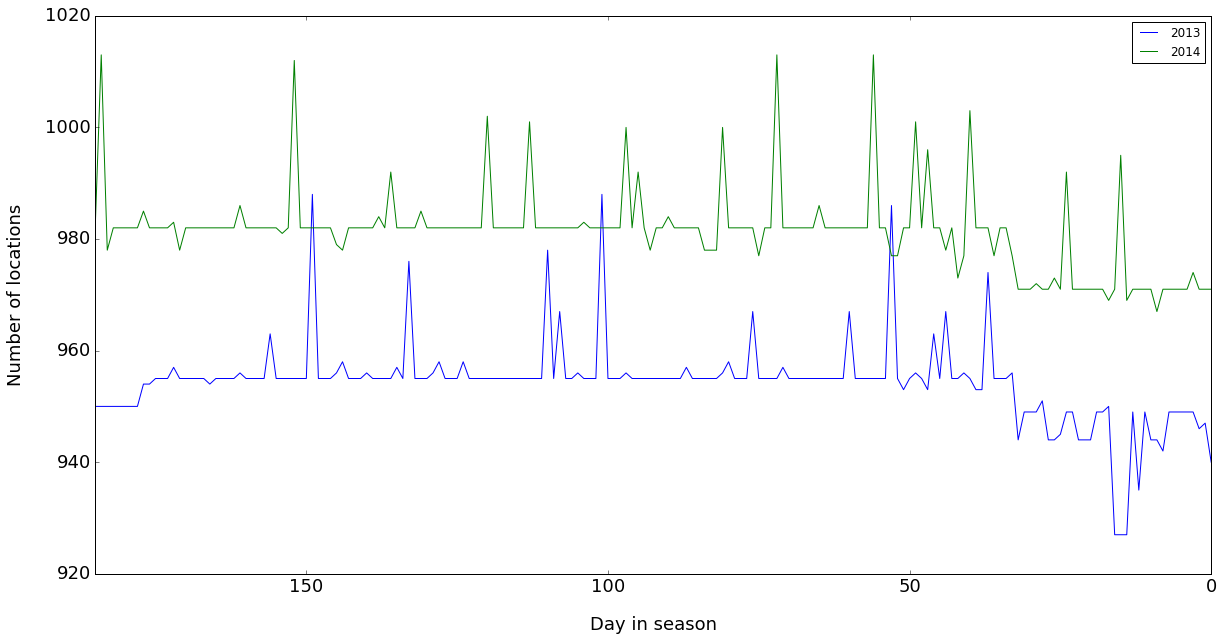

In [120]:
fig, ax = plt.subplots(figsize=(20, 10))

# Make sure it's sorted
dis_2013.sort()
# Walk through data
locs_per_dis = {}
for day in dis_2013:
    locs = df_2013['Location'][df_2013['DayInSeason'] == day].unique()
    locs_per_dis[day] = len(locs)
x = locs_per_dis.keys()
y = locs_per_dis.values()
ax.plot(x,y, label='2013')

# Make sure it's sorted
dis_2014.sort()
# Walk through data
locs_per_dis = {}
for day in dis_2014:
    locs = df_2014['Location'][df_2014['DayInSeason'] == day].unique()
    locs_per_dis[day] = len(locs)
x = locs_per_dis.keys()
y = locs_per_dis.values()
ax.plot(x,y, label='2014')



# Style panel
ax.yaxis.set_ticks_position('left')
ax.set_ylabel('Number of locations',fontsize=18,labelpad=20 )
ax.yaxis.set_label_position("left")
ax.set_xlim(185,0)
ax.set_xlabel('Day in season',fontsize=18,labelpad=20 )
ax.tick_params(labelsize=18)
plt.legend();



There seems to be no clear trend of how or when locations enter/exit the dataset.

In [122]:
date_2013 = df_2013['Date'].unique()
date_2014 = df_2014['Date'].unique()


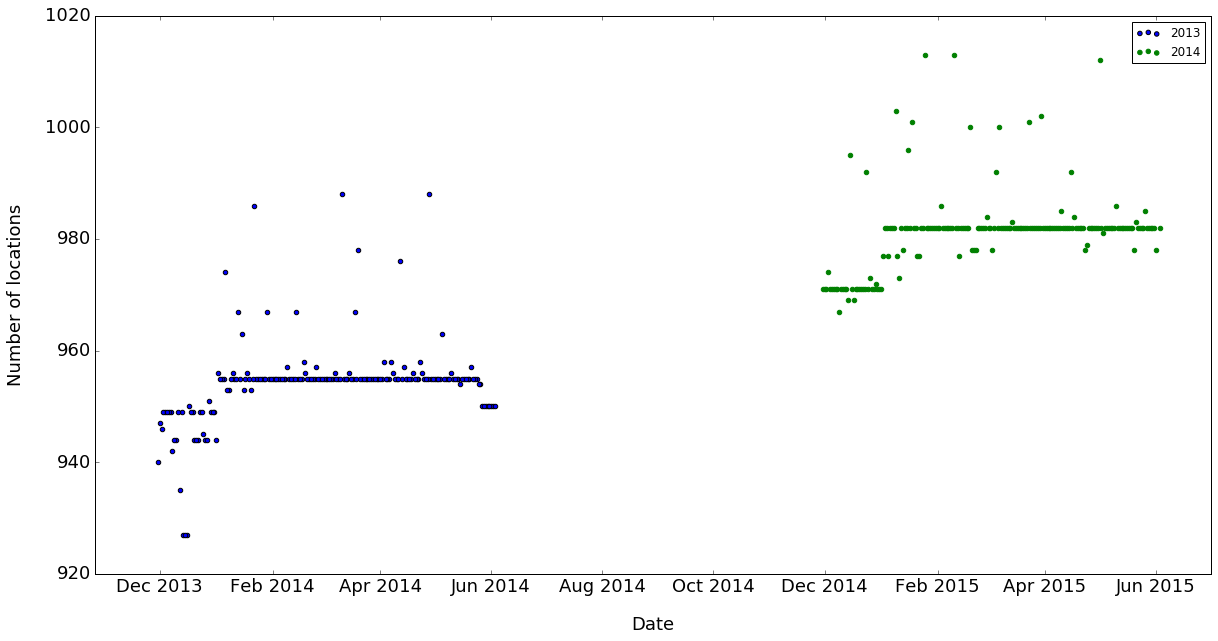

In [128]:
fig, ax = plt.subplots(figsize=(20, 10))


# Make sure it's sorted
date_2013.sort()
# Walk through data
locs_per_date = {}
for day in date_2013:
    locs = df_2013['Location'][df_2013['Date'] == day].unique()
    locs_per_date[day] = len(locs)
x = locs_per_date.keys()
y = locs_per_date.values()
ax.scatter(x,y,label='2013')

# Make sure it's sorted
date_2014.sort()
# Walk through data
locs_per_date = {}
for day in date_2014:
    locs = df_2014['Location'][df_2014['Date'] == day].unique()
    locs_per_date[day] = len(locs)
x = locs_per_date.keys()
y = locs_per_date.values()
ax.scatter(x,y,color='g',label='2014')


# Style panel
ax.yaxis.set_ticks_position('left')
ax.set_ylabel('Number of locations',fontsize=18,labelpad=20 )
ax.yaxis.set_label_position("left")
# ax.set_xlim(185,0)
ax.set_xlabel('Date',fontsize=18,labelpad=20 )
ax.tick_params(labelsize=18)
plt.legend();




Not surprisingly, this plot reflects what I see for the 'DayInSeason' plot above. There is clear baseline around ~955 locations, with positive spikes up to 985 locations. At the very beginning of the season there is a slow ramp up over a month. 

As further check to understand the data, let's see how often each unique location appears in the data. Locations with only very few records have potentially limited use for a prediction.

In [129]:
n_records_2013 = df_2013.groupby(by='Location').agg({'Location': {'Count' : lambda x: x.count()}})
n_records_2013['Location']['Count'].value_counts().sort_index(ascending=False)

186    901
185     10
184      2
183     26
178      5
174      3
169      2
153      6
13       2
9        1
8        2
7        4
6        4
5       21
4        6
3        5
2        2
1       12
Name: Count, dtype: int64

In [130]:
n_records_2014 = df_2014.groupby(by='Location').agg({'Location': {'Count' : lambda x: x.count()}})
n_records_2014['Location']['Count'].value_counts().sort_index(ascending=False)

186    949
185     13
178      3
177      6
154      7
153      4
14       1
13       1
11       3
10       1
9        8
8        4
7        4
6       12
4       13
3        6
Name: Count, dtype: int64

In [101]:
klocs = n_records[n_records['Location']['Count'] >= 153].index.get_level_values('Location').values
date = df_2013['Date'].unique()
# Make sure it's sorted
date.sort()
# Walk through data
locs_per_date = {}
for day in date:
    locs = df_2013['Location'][(df_2013['Date'] == day) & (df_2013['Location'].isin(klocs) )].unique()
    locs_per_date[day] = len(locs)

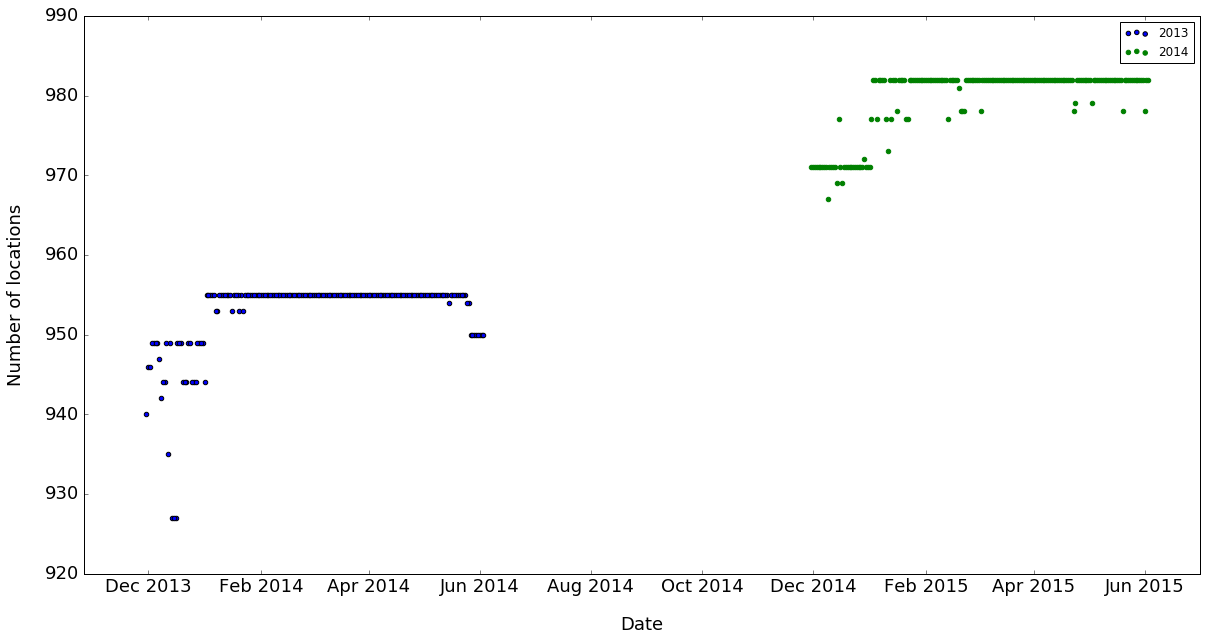

In [132]:
fig, ax = plt.subplots(figsize=(20, 10))


klocs = n_records_2013[n_records_2013['Location']['Count'] >= 153].index.get_level_values('Location').values
# Make sure it's sorted
date_2013.sort()
# Walk through data
locs_per_date = {}
for day in date_2013:
    locs = df_2013['Location'][(df_2013['Date'] == day) & (df_2013['Location'].isin(klocs) )].unique()
    locs_per_date[day] = len(locs)
x = locs_per_date.keys()
y = locs_per_date.values()
ax.scatter(x,y,label='2013')

klocs = n_records_2014[n_records_2014['Location']['Count'] >= 153].index.get_level_values('Location').values
# Make sure it's sorted
date_2013.sort()
# Walk through data
locs_per_date = {}
for day in date_2014:
    locs = df_2014['Location'][(df_2014['Date'] == day) & (df_2014['Location'].isin(klocs) )].unique()
    locs_per_date[day] = len(locs)
x = locs_per_date.keys()
y = locs_per_date.values()

ax.scatter(x,y,color='g',label='2014')


# Style panel
ax.yaxis.set_ticks_position('left')
ax.set_ylabel('Number of locations',fontsize=18,labelpad=20 )
ax.yaxis.set_label_position("left")
# ax.set_xlim(185,0)
ax.set_xlabel('Date',fontsize=18,labelpad=20 )
ax.tick_params(labelsize=18)
plt.legend();





Excluding all locations that have less than 13 (2013) or 14 (2014) records in the dataset removes the upwards scatter from the baseline in the plot.

In [156]:
counts = n_records_2013['Location']['Count'].value_counts().sort_index(ascending=False).values
levels = n_records_2013['Location']['Count'].value_counts().sort_index(ascending=False).index.values

print(counts)
print(levels)

[901  10   2  26   5   3   2   6   2   1   2   4   4  21   6   5   2  12]
[186 185 184 183 178 174 169 153  13   9   8   7   6   5   4   3   2   1]


In [158]:
nrecords = 0
nloc = 0
limit = 153
print('2013:')
for x in np.arange(len(counts)):
    if levels[x] < limit:
        nrecords += levels[x]*counts[x]
        nloc += counts[x]
print('Excluded {} rows ({:4.2f}%) and {} locations ({:4.2f}%).'
      .format(nrecords,nrecords*100/df_2013.shape[0],
              nloc, nloc*100/len(df_2013['Location'].unique())))

2013:
Excluded 263 rows (0.15%) and 59 locations (5.82%).


In [160]:
counts = n_records_2014['Location']['Count'].value_counts().sort_index(ascending=False).values
levels = n_records_2014['Location']['Count'].value_counts().sort_index(ascending=False).index.values
nrecords = 0
nloc = 0
limit = 153
print('2014:')
for x in np.arange(len(counts)):
    if levels[x] < limit:
        nrecords += levels[x]*counts[x]
        nloc += counts[x]
print('Excluded {} rows ({:4.2f}%) and {} locations ({:4.2f}%).'
      .format(nrecords,nrecords*100/df_2014.shape[0],
              nloc, nloc*100/len(df_2014['Location'].unique())))

2014:
Excluded 344 rows (0.19%) and 53 locations (5.12%).


Check the geographical distribution of all locations that have less than 153 records:

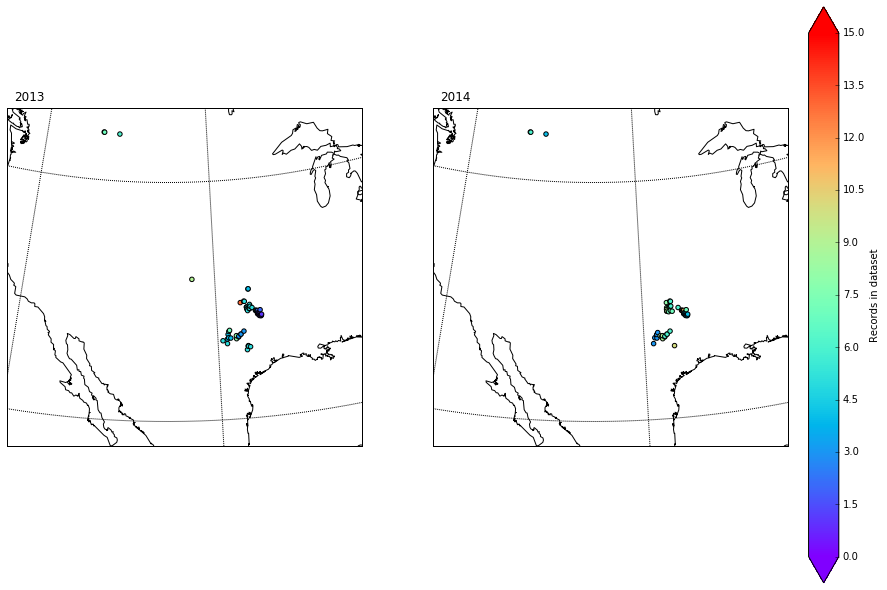

In [161]:
fig, ax = plt.subplots(1,2,figsize=(14, 20))

mymap = Basemap(llcrnrlon=-119, llcrnrlat=22, urcrnrlon=-80,
                urcrnrlat=49, projection='lcc', lat_1=33, lat_2=45,
                lon_0=-105, area_thresh=10000,
                resolution = 'l',ax=ax[0])

klocs = n_records_2013[n_records_2013['Location']['Count'] < 153].index.get_level_values('Location').values
level = n_records_2013['Location']['Count'][n_records_2013['Location']['Count'] < 153].values
# print(locations)
lng = [x[0] for x in klocs]
lat = [x[1] for x in klocs]
yld = level
x,y = mymap(lng, lat)

im1 = mymap.scatter(x, y, c=yld, vmin=0, vmax=15, cmap=mpl.cm.get_cmap('rainbow'), zorder=2)

mymap.drawparallels(np.arange(25,65,20))
mymap.drawmeridians(np.arange(-120,-40,20))
mymap.drawcoastlines()

ax[0].annotate('2013', xy=(0.02, 1.02), fontsize=12,xycoords='axes fraction')

# cax1 = fig.add_axes([0.92, 0.3, 0.03, 0.4])
# cbar = plt.colorbar(im1,cax=cax1, orientation='vertical', extend='both', use_gridspec=True)
# cbar.set_label('Length of Season')

mymap = Basemap(llcrnrlon=-119, llcrnrlat=22, urcrnrlon=-80,
                urcrnrlat=49, projection='lcc', lat_1=33, lat_2=45,
                lon_0=-105, area_thresh=10000,
                resolution = 'l',ax=ax[1])

klocs = n_records_2014[n_records_2014['Location']['Count'] < 153].index.get_level_values('Location').values
level = n_records_2014['Location']['Count'][n_records_2014['Location']['Count'] < 153].values

# print(locations)
lng = [x[0] for x in klocs]
lat = [x[1] for x in klocs]
yld = level
x,y = mymap(lng, lat)

im2 = mymap.scatter(x, y, c=yld, vmin=0, vmax=15, cmap=mpl.cm.get_cmap('rainbow'), zorder=2)

mymap.drawparallels(np.arange(25,65,20))
mymap.drawmeridians(np.arange(-120,-40,20))
mymap.drawcoastlines()

ax[1].annotate('2014', xy=(0.02, 1.02), fontsize=12,xycoords='axes fraction')

cax1 = fig.add_axes( [0.92, 0.3, 0.03, 0.4])
cbar = plt.colorbar(im1,cax=cax1, orientation='vertical', extend='both', use_gridspec=True)
cbar.set_label('Records in dataset')




Comparing the locations with only few records in 2013 and 2014:

In [171]:
klocs_2013 = list(n_records_2013[n_records_2013['Location']['Count'] < 153]
                  .index.get_level_values('Location').values)
klocs_2014 = list(n_records_2014[n_records_2014['Location']['Count'] < 153]
                  .index.get_level_values('Location').values)

matches = set(klocs_2013) & set(klocs_2014)

print('{} locations with low records are common between 2013 and 2014.'.format(len(matches)))

36 locations with low records are common between 2013 and 2014.


For the non-overlapping locations with few records there are two possibilities: either they are not included in the other year's data, or they have a large number of records.

In [172]:
# n_records_2013 = df_2013.groupby(by='Location').agg({'Location': {'Count' : lambda x: x.count()}})


# klocs = n_records_2013[n_records_2013['Location']['Count'] < 153].index.get_level_values('Location').values

klocs_2013 = list(n_records_2013[n_records_2013['Location']['Count'] < 153]
                  .index.get_level_values('Location').values)
klocs_2014 = list(n_records_2014[n_records_2014['Location']['Count'] < 153]
                  .index.get_level_values('Location').values)

locs_2014 = list(df_2014['Location'].unique())
matches = 0
matches_highrec = 0
non_matches = 0
for loc in klocs_2013:
    if loc in locs_2014:
        if loc in klocs_2014:
            matches += 1
        else:
            matches_highrec += 1
    else:
        non_matches += 1
print(matches,matches_highrec,non_matches)

locs_2013 = list(df_2013['Location'].unique())
matches = 0
matches_highrec = 0
non_matches = 0
for loc in klocs_2014:
    if loc in locs_2013:
        if loc in klocs_2013:
            matches += 1
        else:
            matches_highrec += 1
    else:
        non_matches += 1
print(matches,matches_highrec,non_matches)





36 6 17
36 0 17


As I have show above, 36 locations with low record counts are common between both years. In addition, 17 low-record count locations from one year do not show up at all in the other year. And 6 low-record count locations from 2013 actually have high record counts in 2014.

<a id='Precipitation'></a>
## Precipitation

In [212]:
df_2013['precipAccumulation'].value_counts().head(10)

0.000    161454
0.029        93
0.026        87
0.033        85
0.019        85
0.017        81
0.034        80
0.030        79
0.028        78
0.022        77
Name: precipAccumulation, dtype: int64

In [211]:
df_2013['precipIntensity'].value_counts().head(10)

0.0000    124061
0.0001      7344
0.0002      4485
0.0003      3124
0.0004      2511
0.0005      1962
0.0006      1696
0.0007      1442
0.0008      1283
0.0009      1176
Name: precipIntensity, dtype: int64

On most days/locations it does not rain.

In [190]:
# The 'precipAccumulation' column aggregates the total precipitation per day. Now, calculate 
# the total cumulative sum. 
df_2013['precipTotal'] = df_2013.groupby(by='Location')['precipAccumulation'].apply(lambda x: x.cumsum())

In [199]:
# Test that this worked 
locations = df_2013['Location'].unique()
for idx,loc in enumerate(locations):
    if idx < 5:
        tmp1 = df_2013['precipAccumulation'][df_2013['Location'] == loc].sum()
        tmp2 = df_2013['precipTotal'][df_2013['Location'] == loc].max()
        print('{:45} {:6.3f} {:6.3f}'.format(loc, tmp1, tmp2))


(-118.69523719999999, 46.811685799999992)      9.982  9.982
(-118.35210929999998, 46.929839100000002)     12.312 12.312
(-118.5101603, 47.006888099999998)            13.750 13.750
(-118.6996774, 47.162341900000001)            12.934 12.934
(-118.43405590000002, 47.157511999999997)     16.644 16.644


Okay, that seem to have worked!

In [215]:
df_2013.groupby(by='Location').agg({'precipTotal': np.max, 'Yield': np.max}).corr()

,Yield,precipTotal
Yield,1.000000,0.098991
precipTotal,0.098991,1.000000


The correlation between final yield and total amount of precipitation is not too great. But yield is a county average while precipTotal is for individual locations.

Let's try this again on a county basis and averaging the total precipitation values.

In [218]:
df_2013.groupby(by='CountyName').agg({'precipTotal': np.mean, 'Yield': np.max}).corr()

,Yield,precipTotal
Yield,1.0000,0.1178
precipTotal,0.1178,1.0000


Now the correlation is a bit stronger, but still not great. Let's see how it looks:

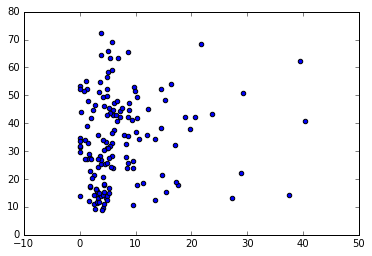

In [221]:
tmp = df_2013.groupby(by='CountyName').agg({'precipTotal': np.mean, 'Yield': np.max})
x = tmp['precipTotal'].values
y = tmp['Yield'].values

plt.scatter(x,y)

<a id='Temperature'></a>
## Temperature

Let's see if I can generate something akin to 'accumulated heat':

In [255]:
df_2013['temperatureDiff'] = df_2013['temperatureMax'] - df_2013['temperatureMin']
df_2013['temperatureRatio'] = df_2013['temperatureMax'] / df_2013['temperatureMin']

In [ ]:
total amount of rain
length of season
temperature profile


<a id='Time series'></a>
## Time series

In this step I will explore the variations of feature values over time for a rabdom location. This may help to identify additonal features that can be engineered.

In [232]:
# Get a random location out of the location set that has the longest season data on record
locations = (gb_agg_2013[gb_agg_2013['DayInSeason']['Length_of_Season'] == 185]
             .index.get_level_values('Location').values)

In [239]:
# Set the seed for reproducability
np.random.seed(seed=1234)
# Randomly choose one entry from the locations subset
idx = np.random.choice(len(locations),1)
location = locations[idx][0]

In [240]:
print(location)

(-96.274679599999999, 33.745539299999997)


In [242]:
dates = df_2013['Date'][df_2013['Location'] == location]
dis = df_2013['DayInSeason'][df_2013['Location'] == location]
print(len(dates.unique()))
print(len(dis.unique()))

186
186


In [256]:
features_to_plot = ['temperatureMax','temperatureMin','temperatureDiff', 'temperatureRatio','NDVI',
                    'Yield','precipIntensity','precipTotal']

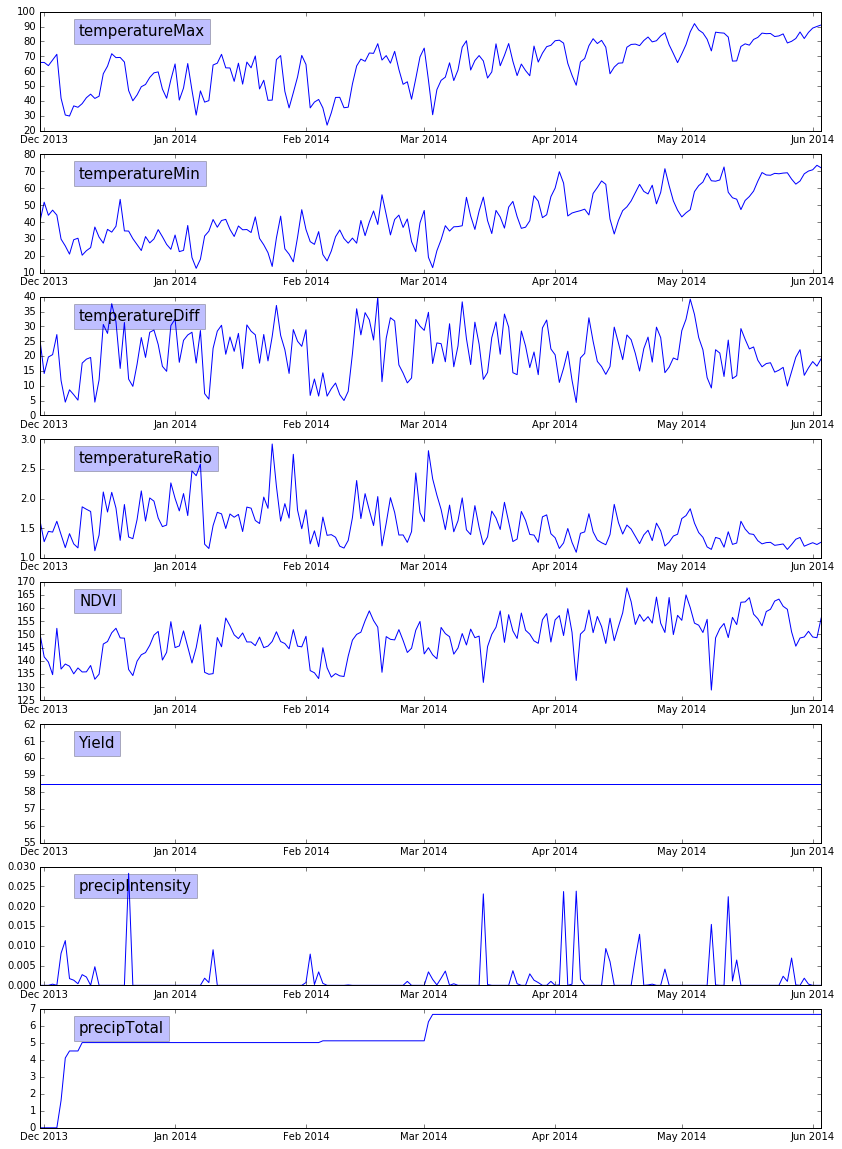

In [258]:
n_plt = len(features_to_plot)
fig, ax = plt.subplots(n_plt,1,figsize=(14, 20))

for i in np.arange(n_plt):
    y = df_2013[features_to_plot[i]][df_2013['Location'] == location]
    ax[i].plot(dates,y)
    ax[i].text(0.05, 0.9, features_to_plot[i],
               verticalalignment='top', horizontalalignment='left',
               transform=ax[i].transAxes,
               color='black', fontsize=15,
               bbox={'facecolor':'blue', 'alpha':0.25, 'pad':5})


In [ ]:
CountyName                  0
State                       0
Latitude                    0
Longitude                   0
Date                        0
apparentTemperatureMax      0
apparentTemperatureMin      0
cloudCover                  0
dewPoint                    0
humidity                    0
precipIntensity             0
precipIntensityMax          0
precipProbability           0
precipAccumulation          0
precipTypeIsRain            0
precipTypeIsSnow            0
precipTypeIsOther           0
pressure                  351
temperatureMax              0
temperatureMin              0
visibility                 16
windBearing                 0
windSpeed                   0
NDVI                        0
DayInSeason                 0
Yield                       0
dtype: int64

<a id='Impute missing values'></a>
## Impute missing values

Because the data are collected in very different areas, a global average can not be used for the imputed value (which are weather data, i.e. local). For each 'NaN' I will get the prior and the next value (according to date) at the same location (according to Latitude and Longitude) and replace the 'NaN' with the average of the other two values.

In [13]:
# Get df for all the NaN values
df_nan = df_2014[df_2014['pressure'].isnull()]

In [14]:
# Go through each entry with 'NaN' in pressure (as an example) and find the bracketing (in time) measure at this location
date_diff = []
for i in range(len(df_nan)):
    tmp_date = df_nan['Date'].iloc[i]
    tmp_long = df_nan['Longitude'].iloc[i]
    tmp_lat  = df_nan['Latitude'].iloc[i]
    condition = ((df_2014['Longitude'] == tmp_long) & 
                 (df_2014['Latitude'] == tmp_lat) & 
                 (df_2014['Date'] > tmp_date)) 
    if len(df_2014['Date'][condition]) > 0:
        date_diff.append(tmp_date-df_2014['Date'][condition].iloc[0])
    # Same location, later dates
    condition = ((df_2014['Longitude'] == tmp_long) & 
                 (df_2014['Latitude'] == tmp_lat) & 
                 (df_2014['Date'] < tmp_date)) 
    if len(df_2014['Date'][condition]) > 0:
        date_diff.append(tmp_date-df_2014['Date'][condition].iloc[0])

In [21]:
# Show min/max of the difference in days between the missing value and the next closest in time at the same location
date_diff_float = [abs(x.days) for x in date_diff]
print('Min: {} ; Max: {} ; Mean : {}'.format(min(date_diff_float),max(date_diff_float),np.mean(date_diff_float)))

Min: 4 ; Max: 169 ; Mean : 48.9235993209


Dates seem to be too sparse to calculate a meaningful replacement value from measurements close in time. Instead use the measurements that are closest geographically and obtained on the same day.

I see missing values in the following fields:

* 2013: precipIntensity, precipIntensityMax, precipProbability, pressure, visibility
* 2014: pressure, visibility     

In [22]:
impute_with_nearest(df_2013, 'precipIntensity')
impute_with_nearest(df_2013, 'precipIntensityMax')
impute_with_nearest(df_2013, 'precipProbability')
impute_with_nearest(df_2013, 'pressure')
impute_with_nearest(df_2013, 'visibility')
# #
impute_with_nearest(df_2014, 'pressure')
impute_with_nearest(df_2014, 'visibility')

In [23]:
# Check result
print(df_2013.isnull().sum().sum())
print(df_2014.isnull().sum().sum())

0
0


### Done!

<a id='Basic statistics'></a>
## Basic statistics

In [24]:
X = df_2013.describe().T
X['missing %'] = 1 - (X['count'] / len(df_2013))
X

,count,mean,std,min,25%,50%,75%,max,missing %
Latitude,177493.0,37.525355,4.918148,27.803015,34.135464,36.810364,38.945878,48.981928,0.0
Longitude,177493.0,-100.877849,5.960510,-120.914093,-101.294945,-99.128028,-97.352044,-94.613571,0.0
apparentTemperatureMax,177493.0,54.836240,23.827278,-39.970000,37.830000,58.880000,73.100000,177.320000,0.0
apparentTemperatureMin,177493.0,27.915526,22.029381,-58.420000,14.310000,26.560000,42.200000,77.180000,0.0
cloudCover,177493.0,0.071478,0.138932,0.000000,0.000000,0.010000,0.090000,1.000000,0.0
dewPoint,177493.0,29.712311,16.687710,-36.090000,19.600000,27.850000,38.890000,75.180000,0.0
humidity,177493.0,0.593973,0.163590,0.080000,0.470000,0.600000,0.720000,1.000000,0.0
precipIntensity,177493.0,0.001158,0.004559,0.000000,0.000000,0.000000,0.000200,0.152900,0.0
precipIntensityMax,177493.0,0.010633,0.044782,0.000000,0.000000,0.000000,0.002800,2.054900,0.0
precipProbability,177493.0,0.133540,0.253415,0.000000,0.000000,0.000000,0.090000,0.960000,0.0


In [25]:
X = df_2014.describe().T
X['missing %'] = 1 - (X['count'] / len(df_2014))
X

,count,mean,std,min,25%,50%,75%,max,missing %
Latitude,182549.0,36.976937,4.926798,27.363741,33.598030,36.164529,38.451645,48.981928,0.0
Longitude,182549.0,-100.547088,5.587446,-120.914093,-101.174610,-99.068063,-97.270576,-94.164602,0.0
apparentTemperatureMax,182549.0,57.146379,20.217840,-24.340000,41.390000,61.460000,72.990000,103.910000,0.0
apparentTemperatureMin,182549.0,33.669343,19.649074,-43.250000,20.890000,33.310000,50.630000,79.560000,0.0
cloudCover,182549.0,0.131278,0.170087,0.000000,0.010000,0.080000,0.180000,1.000000,0.0
dewPoint,182549.0,36.664752,16.202934,-21.950000,25.740000,35.130000,48.840000,78.350000,0.0
humidity,182549.0,0.680338,0.150459,0.140000,0.570000,0.680000,0.800000,1.000000,0.0
precipIntensity,182549.0,0.002501,0.007232,0.000000,0.000000,0.000000,0.001000,0.255800,0.0
precipIntensityMax,182549.0,0.021390,0.071354,0.000000,0.000000,0.000000,0.010100,3.367400,0.0
precipProbability,182549.0,0.205662,0.307787,0.000000,0.000000,0.000000,0.510000,0.970000,0.0


For both years, the (binary) column 'precipTypeIsOther' is always zero (zero std and zero min/max). This feature can be safely dropped as it holds no predictive power.

<a id='Correlations'></a>
## Correlations

Pairwise correlations between different features can help to eliminate features from modeling. Adding highly correlated features can dilute the predictive power of the model. 

In [26]:
# Find all column pairs with correlation coefficients above a certain threshold
X = df_2013.corr()
limit = 0.65
index = X.index.tolist()
n = len(index)
newDF = pd.DataFrame(columns=['col1','col2','corr','corr col1 with target', 'corr col2 with target'])
pos = 0
for nidx,idx in enumerate(index):
    for k in range(n):
        if (k > nidx):
            value = X[idx].iloc[k]
        else:
            value = 0.0
        if value >= limit:
            corr_col1 = X['Yield'].loc[idx]
            corr_col2 = X['Yield'].loc[index[k]]
            newDF.loc[pos] = [idx, index[k] , value, corr_col1, corr_col2]
            pos += 1


In [27]:
newDF.sort_values(by='corr', ascending=False)

,col1,col2,corr,corr col1 with target,corr col2 with target
7,apparentTemperatureMin,temperatureMin,0.992737,-0.049998,-0.060512
2,apparentTemperatureMax,temperatureMax,0.991843,-0.140315,-0.152702
12,precipIntensity,precipIntensityMax,0.912594,0.046476,0.030030
11,dewPoint,temperatureMin,0.910333,0.011607,-0.060512
5,apparentTemperatureMin,dewPoint,0.909563,-0.049998,0.011607
6,apparentTemperatureMin,temperatureMax,0.893452,-0.049998,-0.152702
0,apparentTemperatureMax,apparentTemperatureMin,0.888862,-0.140315,-0.049998
14,temperatureMax,temperatureMin,0.886946,-0.152702,-0.060512
3,apparentTemperatureMax,temperatureMin,0.880383,-0.140315,-0.060512
1,apparentTemperatureMax,dewPoint,0.796342,-0.140315,0.011607


In [28]:
# Find all column pairs with correlation coefficients above a certain threshold
X = df_2014.corr()
limit = 0.65
index = X.index.tolist()
n = len(index)
newDF = pd.DataFrame(columns=['col1','col2','corr','corr col1 with target', 'corr col2 with target'])
pos = 0
for nidx,idx in enumerate(index):
    for k in range(n):
        if (k > nidx):
            value = X[idx].iloc[k]
        else:
            value = 0.0
        if value >= limit:
            corr_col1 = X['Yield'].loc[idx]
            corr_col2 = X['Yield'].loc[index[k]]
            newDF.loc[pos] = [idx, index[k] , value, corr_col1, corr_col2]
            pos += 1


In [29]:
newDF.sort_values(by='corr', ascending=False)

,col1,col2,corr,corr col1 with target,corr col2 with target
2,apparentTemperatureMax,temperatureMax,0.993237,-0.165742,-0.172160
7,apparentTemperatureMin,temperatureMin,0.992886,-0.146381,-0.153430
9,dewPoint,temperatureMin,0.951772,-0.158787,-0.153430
5,apparentTemperatureMin,dewPoint,0.949988,-0.146381,-0.158787
10,precipIntensity,precipIntensityMax,0.863038,-0.015459,-0.020094
0,apparentTemperatureMax,apparentTemperatureMin,0.849104,-0.165742,-0.146381
6,apparentTemperatureMin,temperatureMax,0.844614,-0.146381,-0.172160
3,apparentTemperatureMax,temperatureMin,0.841444,-0.165742,-0.153430
13,temperatureMax,temperatureMin,0.838178,-0.172160,-0.153430
1,apparentTemperatureMax,dewPoint,0.796485,-0.165742,-0.158787


There are a few features that show very strong correlation. For some that is to be expected (apparent temperature vs. temperature, precip intensity vs. max precip intensity, etc).

The 'apparent' temperature values are slightly less correlated with the target variable ('Yield'). I will discard those from further analysis. While 'dew point' and 'temperature min' are highly correlated, thier correlation with 'Yield' has opposite sign (even though the linear correlation itself is weak). I will keep both for now.

<a id='Drop features/columns'></a>
## Drop features/columns

- precipTypeIsOther
- apparentTemperatureMin
- apparentTemperatureMax
- precipIntensityMax


In [30]:
df_2013.drop('precipTypeIsOther', axis=1, inplace=True)
df_2013.drop('apparentTemperatureMin', axis=1, inplace=True)
df_2013.drop('apparentTemperatureMax', axis=1, inplace=True)
df_2013.drop('precipIntensityMax', axis=1, inplace=True)
#
df_2014.drop('precipTypeIsOther', axis=1, inplace=True)
df_2014.drop('apparentTemperatureMin', axis=1, inplace=True)
df_2014.drop('apparentTemperatureMax', axis=1, inplace=True)
df_2014.drop('precipIntensityMax', axis=1, inplace=True)


<a id='Save cleaned data to disk'></a>
## Save cleaned data to disk

In [31]:
df_2013.to_pickle(os.path.join('data','df_2013_clean.df'))
df_2014.to_pickle(os.path.join('data','df_2014_clean.df'))

